In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("/Users/sunilinus/Downloads/Fraud_Detection_Dataset.csv")



In [2]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X192,X193,X194,X195,X196,X197,X198,X199,X200,Response
0,6.5983,-5.4256,-1.6443,13.8045,3.7169,6.7931,14.6561,11.5962,-10.0106,18.7749,...,12.0647,2.1140,11.1032,1.3060,7.7833,-19.1025,13.0473,1.2374,4.9343,1
1,7.5116,-4.3535,-4.0704,14.2800,1.8892,11.8115,14.6331,7.5008,8.7162,10.7818,...,-1.5024,2.8147,18.2737,-3.1967,6.8112,-9.1633,11.0487,1.0700,0.0028,1
2,6.1407,1.3776,-6.5337,13.9074,2.5997,12.1947,14.8693,11.8861,-9.2483,23.8771,...,-6.9850,14.2934,8.2079,-1.7949,5.8634,-32.5582,23.4720,0.3236,8.3363,0
3,6.7580,-4.7164,-0.4525,14.2519,13.4656,5.5629,14.6345,9.9810,-12.0141,17.8304,...,-2.9186,13.1990,3.6219,-9.7055,16.9012,-26.6770,24.9518,-0.2713,1.4283,0
4,6.1647,0.4752,-6.8146,13.7472,11.7696,8.7009,15.0317,9.4731,2.1471,17.5970,...,12.0055,5.0098,2.3963,-14.0838,6.8654,-11.6183,18.4232,0.7031,4.9355,0


In [3]:
# Filling missing values with the mean value of their respective columns
df.fillna(df.mean(), inplace=True)

# Normalizing the dataset features
features = df.columns.tolist()
features.remove('Response')  # Assuming 'Response' is the target variable
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Splitting the dataset
X = df[features]
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:

# Address multicollinearity with PCA
pca = PCA()  # Initialize PCA without specifying components initially
pca.fit(X_train)  # Fit PCA on the training data
variance_ratio = pca.explained_variance_ratio_
threshold = 0.9
n_components = np.where(variance_ratio.cumsum() >= threshold)[0][0] + 1
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [5]:

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)


In [6]:

# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
clf = GradientBoostingClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [7]:

# Best model from hyperparameter tuning
best_model = random_search.best_estimator_


In [9]:

# Predictions on the test set
predictions = best_model.predict(X_test_pca)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[23790  4666]
 [ 1184  2360]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     28456
           1       0.34      0.67      0.45      3544

    accuracy                           0.82     32000
   macro avg       0.64      0.75      0.67     32000
weighted avg       0.88      0.82      0.84     32000



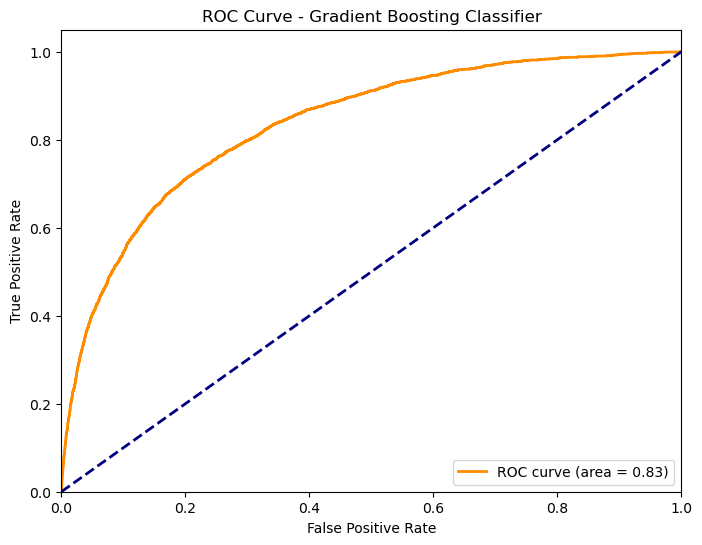

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_score = best_model.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.show()



In [2]:
# Load test data (assuming same preprocessing steps)
testdata = pd.read_csv("/Users/sunilinus/Downloads/Fraud_detection_Test_Perturbed.csv")
testdata.fillna(testdata.mean(), inplace=True)
testdata[features] = scaler.transform(testdata[features])
X_test_pca = pca.transform(testdata[features])

# Make predictions on test data
y_pred = best_model.predict(X_test_pca)

# Create a DataFrame with predictions
df_y = pd.DataFrame(y_pred, columns=['y_hat'])

# Display the first few rows of predictions
print(df_y.head())


NameError: name 'pd' is not defined

In [14]:
df_y.to_csv('Team-8(3-Gradient Boosting).csv', index=False)